In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
Ast = np.load('AR5_estimate.npy')
off_interval = 12 #12
on_interval = 3
max_on = 10
T = 10000
d = 663
Ast_new = Ast

In [548]:
num_neurons = 50
Ast_new = np.zeros((num_neurons,10*num_neurons+1))
for i in range(10):
    Ast_new[:,i*num_neurons:(i+1)*num_neurons] = Ast[0:num_neurons,i*d:i*d+num_neurons]
Ast_new[:,-1] = Ast[0:num_neurons,-1]
d = num_neurons

In [13]:
class Dynamics:
    def __init__(self,Ast,k,batch_size=1,record_history=True):
        self.Ast = Ast
        self.k = k
        self.d = Ast.shape[0]
        self.record_history = record_history
        self.noise_std = 0.1 / np.sqrt(15) #0.001
        self.batch_size = batch_size
        
        self.shift = np.zeros((self.k*self.d,self.k*self.d))
        for i in range(self.k-1):
            self.shift[i*self.d:(i+1)*self.d,self.d+i*self.d:self.d+(i+1)*self.d] = np.eye(self.d)
        self.A_lifted = np.zeros((k*self.d,k*self.d))
        self.A_lifted[(self.k-1)*self.d:,:] = Ast[:,0:self.d*self.k]
        self.A_lifted += self.shift
        self.B_lifted = np.zeros((k*self.d,k*self.d))
        self.B_lifted[(self.k-1)*self.d:,:] = Ast[:,self.d*self.k:2*self.d*self.k]
        self.v = np.zeros((k*self.d))
        self.v[(self.k-1)*self.d:] = Ast[:,-1]
        
        if batch_size > 1:
            self.state = np.zeros((k*self.d,batch_size))
            self.input = np.zeros((k*self.d,batch_size))
        else:
            self.state = np.zeros(k*self.d)
            self.input = np.zeros(k*self.d)
        self.history = []
        
    def step(self,u,noiseless=False):
        next_input = self.shift @ self.input
        next_input[(self.k-1)*self.d:] = u
        if self.record_history:
            self.history.append(np.concatenate((self.state,next_input,[1])))
        next_state = self.A_lifted @ self.state + self.B_lifted @ next_input + self.v
        if not noiseless:
            noise = np.zeros(self.k*self.d)
            noise[(self.k-1)*self.d:self.k*self.d] = self.noise_std * np.random.randn(self.d)
            next_state += noise
        self.state = next_state
        self.input = next_input
        return next_state[(self.k-1)*self.d:], next_state
    
    def step_batch(self,u):
        next_input = self.shift @ self.input
        next_input[(self.k-1)*self.d:,:] = u
        next_state = self.A_lifted @ self.state + self.B_lifted @ next_input + np.outer(self.v,np.ones(self.batch_size))
        self.state = next_state
        self.input = next_input
        return next_state[(self.k-1)*self.d:,:], next_state
    
    def estimate(self):
        hist = np.array(self.history)
        xp = hist[1:,(self.k-1)*self.d:self.k*self.d]
        x = hist[:-1,:]
        e, _ = np.linalg.eig(x.T @ x)
        #print(np.max(e),np.min(e))
        Ahat = np.linalg.pinv(x.T @ x + 0.01 * np.eye(x.shape[1])) @ x.T @ xp
        return Ahat.T
    
    def get_state(self):
        return self.state.copy()
    
    def set_state(self, state):
        if self.batch_size > 1 and len(state.shape) == 1:
            self.state = np.outer(state,np.ones(self.batch_size))
        else:
            self.state = state
            
    def get_states(self):
        hist = np.array(self.history)
        return hist[:,(self.k-1)*self.d:self.k*self.d], hist[:,(2*self.k-1)*self.d:2*self.k*self.d]
    
    
    
class Dynamics_torch:
    def __init__(self,Ast,k,batch_size=1,record_history=True):
        self.Ast = Ast
        self.k = k
        self.d = Ast.shape[0]
        self.record_history = record_history
        self.noise_std = 0.001
        self.batch_size = batch_size
        
        self.shift = torch.zeros((self.k*self.d,self.k*self.d))
        for i in range(self.k-1):
            self.shift[i*self.d:(i+1)*self.d,self.d+i*self.d:self.d+(i+1)*self.d] = torch.eye(self.d)
        self.A_lifted = torch.zeros((k*self.d,k*self.d))
        self.A_lifted[(self.k-1)*self.d:,:] = Ast[:,0:self.d*self.k]
        self.A_lifted += self.shift
        self.B_lifted = torch.zeros((k*self.d,k*self.d))
        self.B_lifted[(self.k-1)*self.d:,:] = Ast[:,self.d*self.k:2*self.d*self.k]
        self.v = torch.zeros((k*self.d))
        self.v[(self.k-1)*self.d:] = Ast[:,-1]
        
        if batch_size > 1:
            self.state = torch.zeros((k*self.d,batch_size))
            self.input = torch.zeros((k*self.d,batch_size))
        else:
            self.state = torch.zeros(k*self.d)
            self.input = torch.zeros(k*self.d)
        self.history = []
        
    def step(self,u,noiseless=False):
        next_input = self.shift @ self.input
        next_input[(self.k-1)*self.d:] = u
        #if self.record_history:
        #    self.history.append(np.concatenate((self.state,next_input,[1])))
        next_state = self.A_lifted @ self.state + self.B_lifted @ next_input + self.v
        #if not noiseless:
        #    noise = torch.zeros(self.k*self.d)
        #    noise[(self.k-1)*self.d:self.k*self.d] = self.noise_std * torch.random.randn(self.d)
        #    next_state += noise
        self.state = next_state
        self.input = next_input
        return next_state[(self.k-1)*self.d:], next_state
    
    def step_batch(self,u,noiseless=False):
        next_input = self.shift @ self.input
        next_input[(self.k-1)*self.d:,:] = u
        next_state = self.A_lifted @ self.state + self.B_lifted @ next_input + torch.outer(self.v,torch.ones(self.batch_size))
        if not noiseless:
            noise = torch.zeros(self.k*self.d,u.shape[1])
            noise[(self.k-1)*self.d:self.k*self.d,:] = self.noise_std * torch.randn(self.d,u.shape[1])
            next_state += noise
        self.state = next_state
        self.input = next_input
        return next_state[(self.k-1)*self.d:,:], next_state
    
    def estimate(self):
        hist = np.array(self.history)
        xp = hist[1:,(self.k-1)*self.d:self.k*self.d]
        x = hist[:-1,:]
        Ahat = torch.linalg.pinv(x.T @ x + 0.01 * torch.eye(x.shape[1])) @ x.T @ xp
        return Ahat.T
    
    def get_state(self):
        return self.state
    
    def set_state(self, state):
        if self.batch_size > 1 and len(state.shape) == 1:
            self.state = torch.outer(state,torch.ones(self.batch_size))
        else:
            self.state = state
            
    def get_states(self):
        hist = torch.array(self.history)
        return hist[:,(self.k-1)*self.d:self.k*self.d], hist[:,(2*self.k-1)*self.d:2*self.k*self.d]

In [6]:
def compute_transfer_matrix(Ahat):
    k = 5
    avg_connect_ark = np.zeros((d,d))
    rollout_len = 1000
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))
        A_params.insert(0,Ahat[:,i*d:(i+1)*d])
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])

    for t in range(rollout_len):
        param_new = np.zeros((d,d))
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t]
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

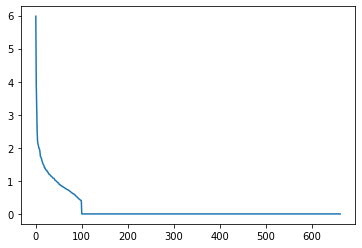

In [741]:
connect_true = compute_transfer_matrix(Ast)
_,S,_ = np.linalg.svd(connect_true)
plt.plot(S)
plt.show()

In [742]:
print(S)

[5.98073632e+00 3.93687775e+00 3.23832280e+00 2.46693913e+00
 2.17572168e+00 2.10056656e+00 2.04381475e+00 1.97914218e+00
 1.96335126e+00 1.88503841e+00 1.73864344e+00 1.72205988e+00
 1.68529899e+00 1.63648456e+00 1.59510881e+00 1.53670970e+00
 1.50993893e+00 1.47819014e+00 1.44961533e+00 1.39613218e+00
 1.39452653e+00 1.36581075e+00 1.32950702e+00 1.32181371e+00
 1.31604894e+00 1.27402271e+00 1.27003569e+00 1.25216291e+00
 1.21186269e+00 1.20544885e+00 1.19238215e+00 1.18352195e+00
 1.15553260e+00 1.14902240e+00 1.13958798e+00 1.12191286e+00
 1.10109931e+00 1.08998004e+00 1.08421718e+00 1.07694702e+00
 1.07313217e+00 1.03678118e+00 1.01945839e+00 1.01572777e+00
 9.97056528e-01 9.87916947e-01 9.69062453e-01 9.56209309e-01
 9.43426379e-01 9.39324500e-01 9.24445245e-01 8.88340566e-01
 8.86705514e-01 8.79822925e-01 8.65504903e-01 8.54512432e-01
 8.50360350e-01 8.31579735e-01 8.28609346e-01 8.22074758e-01
 8.06683232e-01 8.04668132e-01 7.95655015e-01 7.82356173e-01
 7.73430832e-01 7.686547

In [14]:
#d = 5
#max_on = 2
#Ast = 0.1*np.random.randn(d,d*5*2+1)

connect_true = compute_transfer_matrix(Ast_new.copy())
connect_true -= 0.025
connect_true = (connect_true > 0).astype(float)
connect_true = torch.tensor(connect_true)
#connect_true = 1/(1+np.exp(-500*connect_true))
u = np.zeros(d)
loss_fun = torch.nn.BCELoss()

T = 20000
batch_size = 100
rollout_len = 30
num_trials = 1

avg = None

for trial_idx in range(num_trials):
    print(trial_idx)
    cov = np.zeros((2*d,2*d))
    cov = np.zeros((d,d))
    x = np.zeros(d)
    est_error_passive = []
    env = Dynamics(Ast_new,5)
    inputs2 = []

    for t in range(T):
        if np.mod(t,off_interval + on_interval) == 0:
            #num_on = np.random.randint(1,max_on+1)
            num_on = 10 #max_on
            on_idx = np.random.choice(np.linspace(0,d-1,d).astype(int),num_on,replace=False)
            u = np.zeros(d)
            u[on_idx] = 1.0
        if np.mod(t,off_interval + on_interval) > on_interval:
            u = np.zeros(d)
        x, _ = env.step(u)

        if np.mod(t,500) == 0 and False:
            print('t = ' + str(t))
        if np.mod(t,1000) == 0 and t > 0 and True:
            print('t = ' + str(t))
            #print('estimating')
            Ahat = env.estimate()
            transfer_est = compute_transfer_gt(Ahat)
            print(np.linalg.norm(Ahat - Ast_new)/np.linalg.norm(Ast_new),np.linalg.norm(transfer_est - transfer_gt))
            #est_error_passive.append(np.linalg.norm(Ahat - Ast_new, 'fro'))
            #connect_est = compute_transfer_matrix(Ahat.copy())
            #connect_est -= 0.025
            #connect_est = 1/(1+np.exp(-500*connect_est))
            #loss = loss_fun(torch.tensor(connect_est),connect_true)
            #est_error_passive.append(loss.numpy())
            #est_error_passive.append(np.linalg.norm(connect_est - connect_true, 'fro'))
            #print(est_error_passive[-1])
            #print('done estimating')  
    Ahat = env.estimate()
    connect_est = compute_transfer_matrix(Ahat.copy())
    connect_est -= 0.025
    connect_est = 1/(1+np.exp(-500*connect_est))
    loss = loss_fun(torch.tensor(connect_est),connect_true)
    est_error_passive.append(loss.numpy())
    #est_error_passive.append(np.linalg.norm(connect_est - connect_true, 'fro'))
    
    if avg is None:
        avg = np.array(est_error_passive) / num_trials
    else:
        avg += np.array(est_error_passive) / num_trials
est_error_passive = avg
#est_error_passive.append(np.linalg.norm(Ahat - Ast_new, 'fro'))
#print(est_error_passive)
#plt.plot(est_error_passive)

0
t = 1000
1.2501734470966095 24.723070951355425
t = 2000
1.6309131392013934 29.685394749575433
t = 3000
2.2418451710106955 43.25339334962001
t = 4000
3.317851501135739 96.31529383160282
t = 5000
4.6020549593571785 362.85535642083227
t = 6000
3.9466417856709985 180.25882794316757
t = 7000
3.356731480893759 126.02074455662066
t = 8000
3.217441365411545 123.85332844708053
t = 9000


KeyboardInterrupt: 

In [11]:
def compute_transfer_matrix2(Ahat,rollout_len):
    k = 5
    avg_connect_ark = np.zeros((d,d))
    #rollout_len = 15
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))
        A_params.insert(0,Ahat[:,i*d:(i+1)*d])
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])

    for t in range(rollout_len):
        param_new = np.zeros((d,d))
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t] 
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

def compute_transfer_gt(Ast_new):
    transfer_gt = compute_transfer_matrix2(Ast_new, rollout_len=15)
    transfer_gt += compute_transfer_matrix2(Ast_new, rollout_len=14)
    transfer_gt += compute_transfer_matrix2(Ast_new, rollout_len=13)
    return transfer_gt

# transfer_gt = compute_transfer_gt(Ast_new)
# transfer_est = compute_transfer_gt(Ahat)
print(np.linalg.norm(transfer_gt - transfer_est))
print(np.linalg.norm(transfer_gt))

16.256721896546278
23.020160648180894


In [19]:
def batch_sm_update(A_inv,z):
    x = np.einsum('ijk,jk->ik',A_inv,z)
    y = np.einsum('ij,kj->ikj',x,x)
    denom = 1 + np.einsum('ij,ij->j',x,z)
    return A_inv - y / denom[None,None,:]
    
def compute_input(Ahat,x0,batch_size,rollout_len,cov):
    u_batch = []
    for i in range(batch_size-1):
        num_on = np.random.randint(0,max_on+1)
        on_idx = np.random.choice(np.linspace(0,d-1,d).astype(int),num_on,replace=False)
        u = np.zeros(d)
        u[on_idx] = 1.0
        u_batch.append(u)
    u_batch.append(np.zeros(d))
    u_batch2 = np.array(u_batch).T
    
    env_hat = Dynamics(Ahat,5,batch_size=batch_size)
    env_hat.set_state(x0)
    next_state = env_hat.get_state()[4*d:5*d,:]
    cov_inv = np.linalg.pinv(cov + 0.001*np.eye(d))
    cov_inv = np.repeat(cov_inv[...,None], batch_size, axis=2)
    
    for t in range(rollout_len):
        if t == on_interval:
            u_batch2 = np.zeros_like(u_batch2)
        #z = np.concatenate((next_state,u_batch2), axis=0)
        z = next_state
        #cov += np.einsum('ik, jk -> ijk',z,z)
        cov_inv = batch_sm_update(cov_inv, z)
        next_state, _ = env_hat.step_batch(u_batch2)
        
#     nnz_evals = []
#     vals = []
#     for i in range(batch_size):
#         e = np.linalg.eigvalsh(cov[:,:,i])
#         nnz_evals.append(np.count_nonzero(e > 0.01))
#         vals.append(np.mean(e))
#     print(np.max(nnz_evals),np.min(nnz_evals))
#     return u_batch[np.argmax(nnz_evals)]
    vals = []
    for i in range(batch_size):
        vals.append(np.trace(cov_inv[:,:,i]))
    #print(np.max(vals),np.min(vals))
    return u_batch[np.argmin(vals)]

In [20]:
env = Dynamics(Ast_new,5)
u = np.zeros(d)
est_error_active = []

T = 100000
batch_size = 100
rollout_len = 30

cov = np.zeros((2*d,2*d))
cov = np.zeros((d,d))
x = np.zeros(d)

inputs2 = []

for t in range(T):
    if np.mod(t,off_interval + on_interval) == 0:
        if t < 10:
            num_on = np.random.randint(1,max_on+1)
            on_idx = np.random.choice(np.linspace(0,d-1,d).astype(int),num_on,replace=False)
            u = np.zeros(d)
            u[on_idx] = 1.0
        else:
            x0 = env.get_state()
            u = compute_input(Ast_new,x0.copy(),batch_size,rollout_len,cov.copy())
    if np.mod(t,off_interval + on_interval) > on_interval:
        u = np.zeros(d)
    #u = u_test_full[t,:]
    #z = np.concatenate((x,u))
    z = x
    cov += np.outer(z,z)
    inputs2.append(u)
    x, _ = env.step(u)
    
    if np.mod(t,1000) == 0:
        print('t = ' + str(t))
    if np.mod(t,10000) == 0 and t > 0:
        print('estimating')
        Ahat = env.estimate()
        est_error_active.append(np.linalg.norm(Ahat - Ast_new,'fro'))
        print('done estimating')   

t = 0
t = 1000
t = 2000
t = 3000
t = 4000
t = 5000
t = 6000
t = 7000
t = 8000
t = 9000
t = 10000
estimating
done estimating
t = 11000
t = 12000
t = 13000
t = 14000
t = 15000
t = 16000
t = 17000
t = 18000
t = 19000
t = 20000
estimating
done estimating
t = 21000
t = 22000
t = 23000
t = 24000
t = 25000
t = 26000
t = 27000
t = 28000
t = 29000
t = 30000
estimating
done estimating
t = 31000
t = 32000
t = 33000
t = 34000
t = 35000
t = 36000
t = 37000
t = 38000
t = 39000
t = 40000
estimating
done estimating
t = 41000
t = 42000
t = 43000
t = 44000
t = 45000
t = 46000
t = 47000
t = 48000
t = 49000
t = 50000
estimating
done estimating
t = 51000
t = 52000
t = 53000
t = 54000
t = 55000
t = 56000
t = 57000
t = 58000
t = 59000
t = 60000
estimating
done estimating
t = 61000
t = 62000
t = 63000
t = 64000
t = 65000
t = 66000
t = 67000
t = 68000
t = 69000
t = 70000
estimating
done estimating
t = 71000
t = 72000
t = 73000
t = 74000
t = 75000
t = 76000
t = 77000
t = 78000
t = 79000
t = 80000
estimating
don

In [ ]:
plt.figure(figsize=(20,10))
neuron = 78
states,inputs = env.get_states()
plt.subplot(1,2,1)
plt.plot(states[:,neuron])
plt.subplot(1,2,2)
plt.plot(inputs[:,neuron])

In [108]:
x_pred = []
x_past = []
k = 5
for i in range(k):
    x_past.append(np.zeros(663))
    inputs2.insert(0, np.zeros(663))
inputs2 = np.array(inputs2)
    
for t in range(T-k):
    z = np.array(x_past).flatten()
    z = np.concatenate((z,inputs2[t:t+k,:].copy().flatten(),np.ones(1)))
    x_next = Ast @ z
    x_past.pop(0)
    x_past.append(x_next.copy())
    x_pred.append(x_next.copy())
    
x_pred = np.array(x_pred)

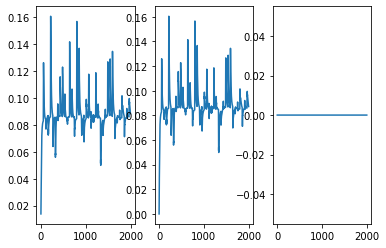

In [124]:
neuron = 59
plt.subplot(1,3,1)
plt.plot(x_pred[:,neuron])
plt.subplot(1,3,2)
plt.plot(states[:,neuron])
plt.subplot(1,3,3)
plt.plot(inputs[:,neuron])

In [132]:
# trial data
data = np.load('sample_photostim_0113.npy', allow_pickle = True).item()
y = data['y']
u = data['u']
num_trials = y.shape[0]
num_steps = y.shape[1]
num_neurons = y.shape[2]
T_before = 4
T_after_start = 9
T_after_end = 13
y_before = np.mean(y[:,:T_before,:],axis = 1)
y_after = np.mean(y[:,T_after_start:T_after_end,:],axis = 1)

y_session = data['y_session']
u_session = data['u_session']
u_session = u_session[4:,:]

test_frac = 0.2
T = u_session.shape[0]
u_train_full = u_session[0:int((1-test_frac)*T),:]
u_test_full = u_session[int((1-test_frac)*T):,:]

In [ ]:
n = 10
A_inv = np.random.randn(5,5,n)
for i in range(n):
    A_inv[:,:,i] = A_inv[:,:,i] @ A_inv[:,:,i].T
u_list = np.random.randn(5,n)

x = np.einsum('ijk,jk->ik',A_inv,u_list)
# for i in range(n):
#     print(np.linalg.norm(A_inv[:,:,i] @ u_list[:,i] - x[:,i]))

y = np.einsum('ij,kj->ikj',x,x)
denom = 1 + np.einsum('ij,ij->j',x,u_list)

A_inv_new = A_inv - y / denom[None,None,:]

for i in range(n):
    A_inv_true = np.linalg.inv(np.linalg.inv(A_inv[:,:,i]) + np.outer(u_list[:,i],u_list[:,i]))
    print(np.linalg.norm(A_inv_true - A_inv_new[:,:,i]))
    

[16.75832597892746, 19.204492571694246, 22.24258780558826, 26.015809415272095, 31.00626158140266]


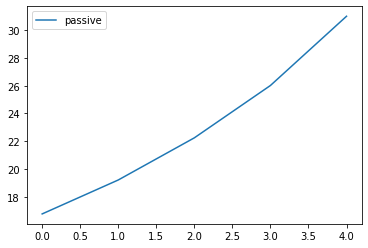

In [6]:
plt.plot(est_error_passive,label='passive')
#plt.plot(est_error_active,label='active')
plt.legend()
print(est_error_passive)

In [ ]:
# u_batch2 = 0.01*torch.randn(d,num_batches)
# u_batch2 = project_inputs(u_batch2)
# cov = compute_cov(torch.tensor(Ast_new.copy()),num_batches,u_batch2)
# loss = torch.trace(torch.linalg.inv(cov + 0.0001*torch.eye(2*d)))
# print(loss.item())

# min_loss = 0
# min_u = None
# for t in range(1000):
#     u_batch = torch.randn(d,num_batches)
#     u_batch = project_inputs(u_batch)
#     u_batch.clamp_(min=0,max=1)
#     cov = compute_cov(torch.tensor(Ast_new.copy()),num_batches,u_batch)
#     e,_ = torch.linalg.eig(cov)
#     loss = torch.min(torch.abs(e))
#     if np.mod(t,100) == 0:
#         print(t)
#     if loss > min_loss:
#         print(loss)
#         min_loss = loss
#         min_u = u_batch.clone()
# u_batch = min_u


def project_inputs2(u_batch,num_on):
    batch_size = u_batch.shape[1]
    for i in range(batch_size):
        sort_idx = torch.argsort(u_batch[:,i], descending=True)
        u_batch[sort_idx[num_on:],i] = 0.0
    return u_batch

connect_true = compute_transfer_matrix(Ast_new.copy())
nums_on = [1,5,10,20,40]
#nums_on = [max_on]
error = []
u_batch0 = torch.rand(d,num_batches)

for num_on_idx in range(len(nums_on)):
    print(num_on_idx)
    u_batch = project_inputs2(u_batch0.clone(),nums_on[num_on_idx])
    
    env = Dynamics(Ast_new,5)
    u = np.zeros(d)
    est_error_random_offline = []
    T = 100000
    idx = 0
    play_count = 0
    max_idx = u_batch.shape[1]
    #input_interval = 50
    input_interval = off_interval + on_interval
    max_play = int(T / (max_idx * input_interval))

    for t in range(T):
        if np.mod(t,input_interval) == 0:
            u = u_batch[:,idx].clone().detach().numpy()
            idx += 1
            #idx = 0
            if idx == max_idx:
                idx = 0
#             play_count += 1
#             if play_count == max_play:
#                 play_count = 0
#                 idx += 1
#             if idx == max_idx:
#                 idx = 0
        if np.mod(t,input_interval) > on_interval:
            u = np.zeros(d)
        x, _ = env.step(u) 
        if np.mod(t,10000) == 0 and t > 0 and True:
            Ahat = env.estimate()
            connect_est = compute_transfer_matrix(Ahat.copy())
            est_error_random_offline.append(np.linalg.norm(connect_est - connect_true, 'fro'))
            #est_error_active2.append(np.linalg.norm(Ahat - Ast_new, 'fro'))
    Ahat = env.estimate()
    connect_est = compute_transfer_matrix(Ahat.copy())
    est_error_random_offline.append(np.linalg.norm(connect_est - connect_true, 'fro'))
    #est_error_active2.append(np.linalg.norm(Ahat - Ast_new, 'fro'))
    error.append(est_error_random_offline)

In [ ]:
Bst = Ast_new[:,5*d:10*d]
Bhat = Ahat[:,5*d:10*d]

Ast_only = Ast_new[:,0:5*d]
Ahat_only = Ahat[:,0:5*d]

# print(np.linalg.norm(Bst,'fro'),np.linalg.norm(Bhat,'fro'))
# print(np.linalg.norm(Bst - Bhat, 'fro'))
# print(np.linalg.norm(Ast_only, 'fro'))
# print(np.linalg.norm(Ast_only - Ahat_only, 'fro'))

plt.figure()
for i in range(len(nums_on)):
    plt.plot(error[i], label='num on = ' + str(nums_on[i]))
#plt.plot(error_old[0], label='old')
plt.legend()
plt.show()

#print(error)
#print(error_old)

# Offline Design

In [25]:
for i in range(10):
    e,_ = np.linalg.eig(Ast_new[:,i*num_neurons:(i+1)*num_neurons])
    print(np.max(np.abs(e)))

0.11755653894103435
0.09565496971483438
0.10544736459386202
0.21635426738704241
0.5396578752128274
0.014506560271339886
0.01988530750406145
0.016712091680822532
0.024922846746089324
0.03594486481024953


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 46.52812194824219 tensor(11501)
50 45.89244842529297 tensor(13918)
100 43.02989959716797 tensor(13475)
150 41.526763916015625 tensor(13032)
200 39.85517883300781 tensor(12757)
250 38.95341491699219 tensor(12602)
300 37.7085075378418 tensor(12457)
350 37.07917022705078 tensor(12335)
400 35.84734344482422 tensor(12263)
450 36.03993606567383 tensor(12178)
500 35.42265319824219 tensor(12105)
550 34.96076202392578 tensor(12035)
600 34.847599029541016 tensor(11958)
650 34.990360260009766 tensor(11904)
700 33.79232406616211 tensor(11843)
750 33.670101165771484 tensor(11800)
800 33.54631042480469 tensor(11760)
850 33.501895904541016 tensor(11725)
900 33.32033157348633 tensor(11650)
950 32.571311950683594 tensor(11598)
1000 32.55824661254883 tensor(11577)
1050 33.23073959350586 tensor(11535)
1100 32.302547454833984 tensor(11480)
1150 32.463626861572266 tensor(11441)
1200 32.710391998291016 tensor(11402)
1250 32.36752700805664 tensor(11383)
1300 32.32830047607422 tensor(11349)
1350 32.28336715

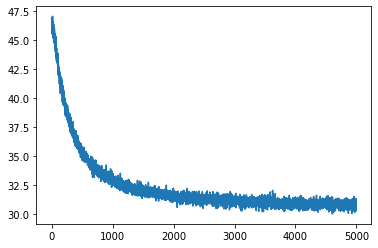

In [734]:
def compute_cov(Ahat,batch_size,u_batch):
    env_hat = Dynamics_torch(Ahat,5,batch_size=batch_size)
    env_hat.set_state(torch.zeros(5*d))
    u_batch2 = u_batch
    #cov = torch.zeros((d*2,d*2))
    cov = torch.zeros((d*2*5,d*2*5))
    next_state = torch.zeros((d,batch_size))
    u_past = []
    x_past = []
    for i in range(5):
        u_past.append(torch.zeros_like(u_batch))
        x_past.append(torch.zeros_like(u_batch))
    for t in range(off_interval+on_interval): 
        if t == on_interval:
            u_batch2 = torch.zeros_like(u_batch2)
        u_past.pop(0)
        u_past.append(u_batch2)
        z = torch.zeros((d*2*5,batch_size))
        for i in range(5):
            z[d*i:d*(i+1),:] = x_past[i]
            z[5*d+d*i:5*d+d*(i+1),:] = u_past[i]
        #z = torch.concat((next_state,u_batch2), axis=0)
        cov = cov + z @ z.T
        next_state, _ = env_hat.step_batch(u_batch2)
        x_past.pop(0)
        x_past.append(next_state)
    return cov

# def compute_cov(Ahat,batch_size,u_batch):
#     env_hat = Dynamics_torch(Ahat,5,batch_size=1)
#     env_hat.set_state(torch.zeros(5*d))
#     u_batch2 = torch.zeros(d)
#     cov = torch.zeros((d*2,d*2))
#     next_state = torch.zeros(d)
#     #for t in range(on_interval + off_interval):
#     idx = 0
#     for t in range(batch_size*(on_interval+off_interval)):
#         if np.mod(t,on_interval+off_interval) < on_interval:
#             z = torch.concat((next_state,u_batch[:,idx]))
#             cov = cov + torch.outer(z,z)
#             next_state, _ = env_hat.step(u_batch[:,idx],noiseless=True)
#         else:
#             z = torch.concat((next_state,u_batch2))
#             cov = cov + torch.outer(z,z)
#             next_state, _ = env_hat.step(u_batch2,noiseless=True)
#         if np.mod(t,on_interval+off_interval) == on_interval:
#             idx += 1
#     return cov

def project_inputs(u_batch):
#     if torch.linalg.norm(u_batch) > 10:
#         return (10 * u_batch / torch.linalg.norm(u_batch)).requires_grad_()
#     return u_batch

    batch_size = u_batch.shape[1]
    for i in range(batch_size):
        #small_idx = u_batch[:,i] < 0.5
        #u_batch[:,small_idx] = 0.0
        sort_idx = torch.argsort(u_batch[:,i], descending=True)
        u_batch[sort_idx[max_on:],i] = 0.0
        #u_batch[sort_idx[:max_on],i] = 1.0
#         large_idx = u_batch[:,i] >= 0.5
#         u_batch[large_idx,i] = 1.0
#         negative_idx = u_batch[:,i] < 0.5
#         u_batch[negative_idx,i] = 0.0
    return u_batch
    
    

#T = 10000
num_batches = 500
#u_batch = []
#for i in range(num_batches):
#    u_batch.append(torch.tensor(0.01*torch.randn(d), requires_grad=True))
u_batch = torch.tensor(0.1*torch.randn(d,num_batches), requires_grad=True)
with torch.no_grad():
    u_batch.clamp_(min=0,max=1)
optimizer = optim.SGD([u_batch], lr=0.5)
lam = 0.001
hess_norm = hess / torch.linalg.norm(hess)

num_random = int(50000 / (15*2))
u_random = np.random.rand(d,num_random)
u_random = u_random > 0.8
u_random = torch.tensor(u_random)
cov_random = compute_cov(torch.tensor(Ast_new.copy()),num_random,u_random) / num_random

loss_vals = []
hess_thresh2 = hess_thresh / torch.linalg.norm(hess_thresh)
e,U = torch.linalg.eig(hess_thresh2)
hess_thresh2 = torch.real(U) @ torch.diag(torch.abs(e)) @ torch.real(U).T
hess_thresh2 = hess_thresh2.float()
for n in range(5000):
    #u_random = np.random.rand(d,num_batches)
    #u_random = u_random > 0.8
    #u_random = torch.tensor(u_random)
    #cov_random = compute_cov(torch.tensor(Ast_new.copy()),num_batches,u_random) / num_batches
    optimizer.zero_grad()
    cov = compute_cov(torch.tensor(Ast_new.copy()),num_batches,u_batch) / num_batches
    loss = torch.trace(hess_thresh2 @ torch.linalg.inv(cov_random + cov + 0.000001*torch.eye(2*d*5)))
    #loss += lam * torch.linalg.norm(u_batch, 1)
    #e,_ = torch.linalg.eig(cov)
    #loss = -torch.min(torch.abs(e))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
#     if np.mod(n,50) == 0 and n > 0:
#         with torch.no_grad():
#             u_batch = project_inputs(u_batch)
    with torch.no_grad():
        u_batch.clamp_(min=0,max=1)
    if np.mod(n,50) == 0:
        nnz = torch.sum(u_batch > 0.01)
        print(n,loss_val,nnz)
    loss_vals.append(loss_val)

#cov = compute_cov(torch.tensor(Ast_new.copy()),50,u_batch)
#cov = cov.detach().numpy()
#cov_inv = np.linalg.inv(cov + 0.0001*np.eye(2*d))
#print(np.trace(cov_inv))
# with torch.no_grad():
#     u_batch = project_inputs(u_batch)
# cov = compute_cov(torch.tensor(Ast_new.copy()),num_batches,u_batch)
# loss = torch.trace(torch.linalg.inv(cov + 0.0001*torch.eye(2*d)))
# print(loss.item())
#with torch.no_grad():
#     u_batch = project_inputs(u_batch)
plt.plot(loss_vals[5:])

27.25
0.11008818


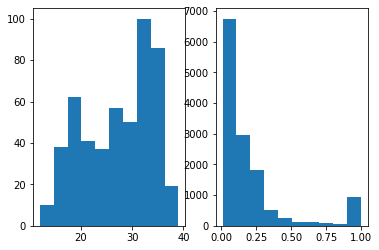

In [699]:
u_batch_np = u_batch.clone().detach().numpy()
# u_nnz = u_batch_np > 0
# plt.hist(u_batch_np[u_nnz].flatten())
# plt.plot()

nnz_column = np.sum(u_batch_np > 0.01, axis=0)
plt.subplot(1,2,1)
plt.hist(nnz_column)
plt.plot()
plt.subplot(1,2,2)
plt.hist(u_batch_np[u_batch_np > 0.01].flatten())

print(np.mean(nnz_column))
print(np.mean(u_batch_np.flatten()))
#print(nnz_column)

# plt.hist(np.linalg.norm(u_batch_np, axis=1))
# plt.plot()

#print(np.max(u_batch_np))

In [736]:
#d = 5
#max_on = 2
#Ast = 0.1*np.random.randn(d,d*5*2+1)
# with torch.no_grad():
#     #u_batch.clamp_(min=0,max=1)
#     u_batch = project_inputs(u_batch)

u = np.zeros(d)
connect_true = compute_transfer_matrix(Ast_new.copy())
connect_true -= 0.025
connect_true = (connect_true > 0).astype(float)
connect_true = torch.tensor(connect_true)
#connect_true = 1/(1+np.exp(-500*connect_true))
#u_batch = min_u.clone()
loss_fun = torch.nn.BCELoss()

# u_batch = u_batch.detach()
# u_batch[u_batch > 0] = 1.0

T = 50000
num_trials = 10

play_count = 0
max_idx = u_batch.shape[1]

avg = None

def get_idx(num_on):
    new_idx = []
    while len(new_idx) < num_on:
        if np.random.rand() > 0.4:
            idx_rand = np.random.choice(important_neuron_idx,1)
        else:
            idx_rand = np.random.choice(other_neuron_idx,1)
        if idx_rand not in new_idx:
            new_idx.append(idx_rand)
    return np.array(new_idx).astype(int)
            
for trial_idx in range(num_trials):
    print(trial_idx)
    idx = 0
    input_interval = off_interval + on_interval
    #input_interval = 50
    max_play = int(T / (max_idx*input_interval))
    idx2 = 0
    est_error_active = []
    env = Dynamics(Ast_new,5)
    
    for t in range(T):
        if np.mod(t,input_interval) == 0:
            if np.mod(idx2,2) != 0:
                u = u_batch[:,idx].clone().detach().numpy()
                idx += 1
                if idx == max_idx:
                    idx = 0
                play_count += 1
                if play_count == max_play:
                    play_count = 0
                    idx += 1
                if idx == max_idx:
                    idx = 0
            else:
                num_on = 10
                #on_idx = get_idx(num_on)
                #on_idx1 = np.random.choice(important_neuron_idx,7,replace=False)
                #on_idx2 = np.random.choice(other_neuron_idx,7,replace=False)
#                 on_idx = np.random.choice(np.linspace(0,d-1,d).astype(int),num_on,replace=False)
#                 u = np.zeros(d)
#                 u[on_idx] = 1.0
                u = u_random[:,np.mod(int(idx2 / 2),u_random.shape[1])]
                #u[on_idx2] = 1.0
            idx2 += 1
        if np.mod(t,input_interval) > on_interval:
            u = np.zeros(d)
        x, _ = env.step(u)
        
        if np.mod(t,1000) == 0 and t > 0 and True:
            #print('t = ' + str(t))
            #print('estimating')
            Ahat = env.estimate()
            connect_est = compute_transfer_matrix(Ahat.copy())
            connect_est -= 0.025
            connect_est = 1/(1+np.exp(-500*connect_est))
            loss = loss_fun(torch.tensor(connect_est),connect_true)
            est_error_active.append(loss.numpy())
            #est_error_active.append(np.linalg.norm(connect_est - connect_true, 'fro'))
            #est_error_active.append(np.linalg.norm(Ahat - Ast_new, 'fro'))
            #print(est_error_active[-1])
            #print('done estimating')  
    Ahat = env.estimate()
    connect_est = compute_transfer_matrix(Ahat.copy())
    connect_est -= 0.025
    connect_est = 1/(1+np.exp(-500*connect_est))
    loss = loss_fun(torch.tensor(connect_est),connect_true)
    est_error_active.append(loss.numpy())
    #est_error_active.append(np.linalg.norm(connect_est - connect_true, 'fro'))

    if avg is None:
        avg = np.array(est_error_active) / num_trials
    else:
        avg += np.array(est_error_active) / num_trials
est_error_active = avg
# connect_est = compute_transfer_matrix(Ahat.copy())
# est_error_active.append(np.linalg.norm(connect_est - connect_true, 'fro'))
#est_error_active.append(np.linalg.norm(Ahat - Ast_new, 'fro'))

0
1
2
3
4
5
6
7
8
9


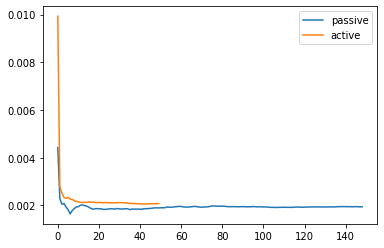

7053.61962890625 10.252


In [737]:
plt.plot(est_error_passive[0:], label='passive')
plt.plot(est_error_active[0:], label='active')
#plt.plot(est_error_random_offline, label='random offline')
#plt.plot(est_error_active2, label='random offline')
#plt.plot(est_error_active2_2, label='active 2')
plt.legend()
plt.show()
print(np.sum(u_batch.detach().numpy())/2+15*max_idx/2,5126/max_idx)

In [731]:
print('test')

test


# Compute Hessian

In [452]:
def compute_transfer_matrix_torch(params_in):
    k = 5
    avg_connect_ark = torch.zeros((d,d), dtype=torch.float)
    rollout_len = 50
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(torch.zeros((d,d), dtype=torch.float))
        A_params.insert(0,params_in[i])
        B_params.insert(0,params_in[i+k])

    for t in range(rollout_len):
        param_new = torch.zeros((d,d), dtype=torch.float)
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t]
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

def loss_hessian(*params):
    #Ahat = torch.reshape(thetahat, (d,d*10+1))
    connect_est = compute_transfer_matrix_torch(params)
    connect_true = torch.tensor(compute_transfer_matrix(Ast_new.copy()), dtype=torch.float)
    return torch.linalg.norm(connect_est - connect_true, 'fro')**2


Ast_torch = torch.tensor(Ast_new.copy(), dtype=torch.float)
thetast = Ast_torch.flatten()

params = []
for i in range(10):
    params.append(torch.autograd.Variable(Ast_torch[:,i*d:(i+1)*d], requires_grad=True))
params = tuple(params)

#thetast = torch.autograd.Variable(thetast, requires_grad=True)
grad = torch.autograd.functional.hessian(loss_hessian,params)
print(len(grad),grad[0].shape)

AttributeError: 'tuple' object has no attribute 'shape'

In [474]:
i = 3
j = 2
X = torch.reshape(grad[i][j], (50*50, 50*50))
X = X.detach().numpy()
print(np.max(X),np.min(X))
#plt.imshow(X, norm=colors.Normalize(vmin=0.0, vmax=.01))

max_norm_diff = 0
for i in range(10):
    for j in range(10):
        for l in range(10):
            for k in range(10):
                X1 = torch.reshape(grad[i][j], (50*50, 50*50))
                X2 = torch.reshape(grad[l][k], (50*50, 50*50))
                norm_diff = torch.linalg.norm(X1 - X2)
                norm_full = torch.linalg.norm(X1)
                if max_norm_diff < norm_diff / norm_full:
                    max_norm_diff = norm_diff / norm_full
print(max_norm_diff)              
# print(torch.linalg.norm(torch.reshape(grad[0][0], (50*50, 50*50)) - torch.reshape(grad[0][1], (50*50, 50*50))))
# print(torch.linalg.norm(torch.reshape(grad[0][0], (50*50, 50*50))))

196.93669 -29.819103
tensor(7.5460)


In [507]:
def compute_transfer_matrix_torch(params_in):
    k = 5
    avg_connect_ark = torch.zeros((d,d), dtype=torch.float)
    rollout_len = 50
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(torch.zeros((d,d), dtype=torch.float))
        Ai = torch.tensor(Ast_new[:,i*d:(i+1)*d].copy(), dtype=torch.float32)
        Bi = torch.tensor(Ast_new[:,k*d+i*d:k*d+(i+1)*d].copy(), dtype=torch.float32)
        Ai[idx,:] = params_in[i]
        Bi[idx,:] = params_in[k+i]
        A_params.insert(0,Ai)
        B_params.insert(0,Bi)

    for t in range(rollout_len):
        param_new = torch.zeros((d,d), dtype=torch.float)
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t]
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

def loss_hessian(*params):
    #Ahat = torch.reshape(thetahat, (d,d*10+1))
    connect_est = compute_transfer_matrix_torch(params)
    connect_true = torch.tensor(compute_transfer_matrix(Ast_new.copy()), dtype=torch.float)
    return torch.linalg.norm(connect_est - connect_true, 'fro')**2


Ast_torch = torch.tensor(Ast_new.copy(), dtype=torch.float)
thetast = Ast_torch.flatten()


#hess = torch.zeros((500,500))
#grads = []

for col_idx in range(d):
    idx = col_idx
    print(idx)
    params = []
    for i in range(10):
        params.append(torch.autograd.Variable(Ast_torch[idx,i*d:(i+1)*d], requires_grad=True))
    params = tuple(params)
    grad2 = torch.autograd.functional.hessian(loss_hessian,params)
#     grads.append(grad2)
#     for i in range(10):
#         for j in range(10):
#             hess[i*50:(i+1)*50,j*50:(j+1)*50] += grad2[i][j]

0
0
0
0
0
0
1
1
1
1
1
1


KeyboardInterrupt: 

[1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847
 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847
 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847
 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847
 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847
 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847
 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1847 1524.1846
 1524.1846]
1524.1847


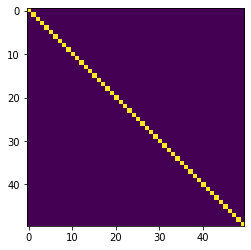

In [513]:
# print(len(grad2),len(grad2[0]),grad2[0][0].shape)
# hess = torch.zeros((500,500))
# for i in range(10):
#     for j in range(10):
#         hess[i*50:(i+1)*50,j*50:(j+1)*50] = grad2[i][j]
hess_view = hess[250:300,250:300].numpy()
plt.imshow(hess_view, norm=colors.Normalize(vmin=0.0, vmax=0.1*np.max(hess_view)))
print(np.diag(hess_view))
print(np.max(np.diag(hess_view)))

# Active learning for thresholded connectivity graph

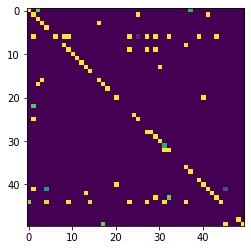

In [575]:
#connect_true_norm = connect_true - np.min(connect_true)
#connect_true_norm = connect_true_norm / np.max(connect_true_norm)
connect_true_norm = connect_true.copy()
connect_true_norm -= 0.025
connect_true_thresh = 1/(1+np.exp(-500*connect_true_norm))
#connect_true_thresh = connect_true_norm > 0.025
plt.imshow(connect_true_thresh, norm=colors.Normalize(vmin=0.3, vmax=1.0))
plt.show()

In [691]:
def compute_transfer_matrix_torch(params_in):
    k = 5
    avg_connect_ark = torch.zeros((d,d), dtype=torch.float)
    rollout_len = 50
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(torch.zeros((d,d), dtype=torch.float))
        Ai = torch.tensor(Ast_new[:,i*d:(i+1)*d].copy(), dtype=torch.float32)
        Bi = torch.tensor(Ast_new[:,k*d+i*d:k*d+(i+1)*d].copy(), dtype=torch.float32)
        Ai[idx,:] = params_in[i]
        Bi[idx,:] = params_in[k+i]
        A_params.insert(0,Ai)
        B_params.insert(0,Bi)

    for t in range(rollout_len):
        param_new = torch.zeros((d,d), dtype=torch.float)
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t]
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    avg_connect_ark -= 0.025
    avg_connect_ark = torch.sigmoid(-500*avg_connect_ark)
    return avg_connect_ark

def loss_hessian(*params):
    #Ahat = torch.reshape(thetahat, (d,d*10+1))
    connect_est = compute_transfer_matrix_torch(params)
    connect_true = torch.tensor(compute_transfer_matrix(Ast_new.copy()), dtype=torch.float)
    connect_true -= 0.025
    connect_true = (connect_true > 0).float() #torch.sigmoid(-10*connect_true)
    loss_fun = torch.nn.BCELoss()
    loss = loss_fun(connect_est,connect_true)
    # loss = torch.linalg.norm(connect_est - connect_true, 'fro')**2
    return loss


Ast_torch = torch.tensor(Ast_new.copy(), dtype=torch.float)
thetast = Ast_torch.flatten()


hess_thresh = torch.zeros((500,500))
grads_thresh = []

for col_idx in range(d):
    idx = col_idx
    print(idx)
    params = []
    for i in range(10):
        params.append(torch.autograd.Variable(Ast_torch[idx,i*d:(i+1)*d], requires_grad=True))
    params = tuple(params)
    grad2 = torch.autograd.functional.hessian(loss_hessian,params)
    grads_thresh.append(grad2)
    num_nan = 0
    for i in range(10):
        for j in range(10):
            num_nan += torch.sum(torch.isnan(grad2[i][j]))
            hess_thresh[i*50:(i+1)*50,j*50:(j+1)*50] += grad2[i][j]
    print(num_nan)

0
tensor(0)
1
tensor(0)
2
tensor(0)
3
tensor(0)
4
tensor(0)
5
tensor(0)
6
tensor(0)
7
tensor(0)
8
tensor(0)
9
tensor(0)
10
tensor(0)
11
tensor(0)
12
tensor(0)
13
tensor(0)
14
tensor(0)
15
tensor(0)
16
tensor(0)
17
tensor(0)
18
tensor(0)
19
tensor(0)
20
tensor(0)
21
tensor(0)
22
tensor(0)
23
tensor(0)
24
tensor(0)
25
tensor(0)
26
tensor(0)
27
tensor(0)
28
tensor(0)
29
tensor(0)
30
tensor(0)
31
tensor(0)
32
tensor(0)
33
tensor(0)
34
tensor(0)
35
tensor(0)
36
tensor(0)
37
tensor(0)
38
tensor(0)
39
tensor(0)
40
tensor(0)
41
tensor(0)
42
tensor(0)
43
tensor(0)
44
tensor(0)
45
tensor(0)
46
tensor(0)
47
tensor(0)
48
tensor(0)
49
tensor(0)


[-3.28938633e+04+0.00000000e+00j  1.53341875e+04+0.00000000e+00j
  1.48060742e+04+0.00000000e+00j  1.28984209e+04+0.00000000e+00j
  9.15136816e+03+0.00000000e+00j -7.67612207e+03+0.00000000e+00j
  7.91855469e+03+0.00000000e+00j  6.55256152e+03+0.00000000e+00j
  5.39332520e+03+0.00000000e+00j -3.20410181e+03+0.00000000e+00j
  2.76772827e+03+0.00000000e+00j -1.49998730e+03+0.00000000e+00j
  1.57813416e+03+0.00000000e+00j  1.54990930e+03+0.00000000e+00j
  1.47072546e+03+0.00000000e+00j  1.41283704e+03+0.00000000e+00j
  1.19989282e+03+0.00000000e+00j -9.49763733e+02+0.00000000e+00j
  1.11205090e+03+0.00000000e+00j  1.00468542e+03+0.00000000e+00j
  8.39665222e+02+0.00000000e+00j  5.94676880e+02+0.00000000e+00j
  5.85689148e+02+0.00000000e+00j  5.22359131e+02+0.00000000e+00j
  4.42636169e+02+0.00000000e+00j -3.61586945e+02+0.00000000e+00j
  2.83249817e+02+0.00000000e+00j  2.42397766e+02+0.00000000e+00j
  2.20857147e+02+0.00000000e+00j -1.59347321e+02+0.00000000e+00j
  1.97682556e+02+0.000000

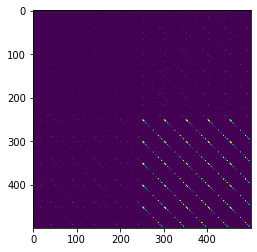

In [692]:
hess_view = hess_thresh.detach().clone().numpy()
#hess_view = hess_view[250:300,250:300]
plt.imshow(hess_view, norm=colors.Normalize(vmin=0.0, vmax=0.1*np.max(hess_view)))
e,_ = np.linalg.eig(hess_view)
print(e)

hess_view = hess_view[250:300,250:300]
hess_view = hess_view - np.min(hess_view)
hess_view = hess_view / np.max(hess_view)
hess_view = hess_view > 0.23
important_neurons = np.diag(hess_view)
print(important_neurons)
print(np.sum(important_neurons))
idx = np.linspace(0,49,50).astype(int)
important_neuron_idx = idx[important_neurons]
other_neuron_idx = idx[~important_neurons]
print(important_neuron_idx)
print(other_neuron_idx)
print(len(important_neuron_idx))


tensor([[ 0.4414, -0.0255,  0.0032,  ..., -0.0250, -0.0174, -0.0310],
        [-0.0263,  0.1705, -0.0411,  ..., -0.0250, -0.0309, -0.0279],
        [-0.0211, -0.0335,  0.0377,  ..., -0.0250, -0.0246, -0.0284],
        ...,
        [-0.0239, -0.0250, -0.0234,  ..., -0.0250, -0.0249, -0.0259],
        [-0.0244, -0.0263, -0.0402,  ..., -0.0250,  0.0552, -0.0396],
        [-0.0250, -0.0214, -0.0286,  ..., -0.0250, -0.0475,  0.0152]])


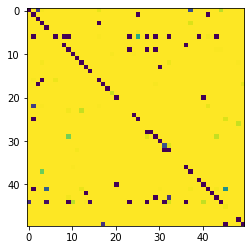

In [652]:
connect_true = torch.tensor(compute_transfer_matrix(Ast_new.copy()), dtype=torch.float)
connect_true -= 0.025
connect_true = torch.sigmoid(-500*connect_true)
plt.imshow(connect_true)